# WSI 2022L
# Laboratorium 3/4 (Algorytm Genetyczny)
# Michał Brus, 299106

# Importy

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Fukncja zysku (z zadania z rakietą)

In [2]:
def profit_function(engine_on_off_vector):
    height = 0
    velocity = 0
    fuel_units_mass = engine_on_off_vector.sum()  # vector consists of 1s and 0s so naturally the sum is a number of 1s
    total_mass = 20 + fuel_units_mass
    for t in range(len(engine_on_off_vector)):
        if engine_on_off_vector[t] == 1:
            total_mass = total_mass - 1
        engine_acceleration = 500 / total_mass
        friction_acceleration = -0.06 * velocity * abs(velocity) / total_mass
        gravity_acceleration = -0.9
        acceleration = engine_acceleration + friction_acceleration + gravity_acceleration
        velocity = velocity + acceleration  # v = v + a*t but t here is 1 time unit every time, so v = v + a
        height = height + velocity + acceleration / 2  # s = s + v*t + 0.5*a*t^2 but t here is 1 time unit every time,
        # so s = s + v + a/2
    if height >= 750:
        return 200 - fuel_units_mass
    else:
        return 0

# Inicjalizacja populacji początkowej

In [3]:
def initialise_population(population_size):
    bits_number = 200
    population = np.empty([population_size, bits_number])
    rng = np.random.default_rng()
    for i in range(population_size):
        population[i] = rng.integers(2, size=bits_number)
    return population

# Ocena jakości danej populacji

In [4]:
def evaluate(population, q_function):
    evaluation = np.empty([population.shape[0]])
    for i in range(len(evaluation)):
        evaluation[i] = q_function(population[i])
    return evaluation

# Selekcja ruletkowa

In [5]:
def roulette_selection(population, evaluation):
    population_size = population.shape[0]
    selection_probability = np.empty([population_size])
    for i in range(len(selection_probability)):
        selection_probability[i] = evaluation[i] / evaluation.sum()
    rng = np.random.default_rng()
    selected = rng.choice(population, population_size, p=selection_probability)  # should it be possible
    # for an individual to be selected more than once? Yes, otherwise everyone would be selected
    return selected

# Krzyżowanie jednopunktowe

In [6]:
def crossover(parent1, parent2, p_crossover):
    have_offspring = True
    rng = np.random.default_rng()
    probability = rng.uniform(0, 1)
    if probability < p_crossover:
        cross_point = rng.integers(200).astype(int)
        child1 = np.concatenate((parent1[:cross_point], parent2[cross_point:]))
        child2 = np.concatenate((parent1[cross_point:], parent2[:cross_point]))
        return have_offspring, child1, child2
    else:
        have_offspring = False
        return have_offspring, parent1, parent2

# Mutacja

In [7]:
def mutate(individual, p_mutation):
    genes_number = len(individual)
    rng = np.random.default_rng()
    p_genes_mutation = rng.uniform(0, 1, size=genes_number)
    for i in range(genes_number):
        if p_genes_mutation[i] < p_mutation:
            individual[i] = 1 if individual[i] == 0 else 0
    return individual

# Reprodukcja (krzyżowanie i mutacja)

In [8]:
def reproduce(p_crossover, p_mutation, selected):
    bits_number = 200
    population_size = selected.shape[0]
    new_population = np.empty([population_size, bits_number])
    for i in range(0, population_size, 2):
        parent1, parent2 = selected[i], selected[i + 1]
        have_offspring, child1, child2 = crossover(parent1, parent2, p_crossover)
        if have_offspring:  # only kids mutate
            child1, child2 = mutate(child1, p_mutation), mutate(child2, p_mutation)
        new_population[i], new_population[i + 1] = child1, child2
    return new_population

# Znalezienie najlepszego kandydata po ocenie populacji

In [9]:
def find_best(evaluation, population):
    index = evaluation.argmax()
    best_value = evaluation[index]
    return best_value, population[index]

# Algorytm genetyczny (wraz z zapisem historii działania)

In [10]:
def genetic_algorithm(q_function, p_mutation, p_crossover, population_size, population_budget):
    gen_max = int(population_budget / population_size)  # population budget and size determine the number of generations
    gen = 0
    population = initialise_population(population_size)
    evaluation = evaluate(population, q_function)
    best_yet = find_best(evaluation, population)
    best_values_history = np.array([best_yet[0]])
    best_points_history = np.array([best_yet[1]])
    generation_mean = evaluation.sum() / len(evaluation)
    generation_mean_history = np.array([generation_mean])
    while gen < gen_max:
        selected = roulette_selection(population, evaluation)
        offspring = reproduce(p_crossover, p_mutation, selected)  # crossover and mutation
        evaluation = evaluate(offspring, q_function)
        best = find_best(evaluation, population)
        best_values_history = np.concatenate((best_values_history, [best[0]]))
        best_points_history = np.concatenate((best_points_history, [best[1]]))
        generation_mean = evaluation.sum() / len(evaluation)
        generation_mean_history = np.concatenate((generation_mean_history, np.array([generation_mean])))
        if best_yet[0] < best[0]:
            best_yet = best
        population = offspring
        gen = gen + 1
    return best_yet, best_values_history, best_points_history, generation_mean_history

best_result, history_of_best, mean = genetic_algorithm(profit_function, 200, 0.01, 0.75, 50)
print(f"Najlepszy wynik: {best_result}")
print(f"Historia najlepszych osobników w każdej generacji: {history_of_best[::, 0]}")
print(f"Historia średnich dla generacji: {mean}")

# Parametry domyślne

In [11]:
total_budget = 10**5
populations = np.array([100, 500, 1000, 2500, 5000])
p_mutations = np.array([0.2, 0.1, 0.05, 0.01, 0.005])
p_crossovers = np.array([0.9, 0.75, 0.6, 0.5, 0.25])

Domyślne ustawienie parametrów: budget = 1mln, populalutaion_size = 300, p_mutation = 0.05, p_crossover = 0.75

# Badanie wpływu rozmiaru populacji na działanie AG

In [ ]:
mean_best_values = np.empty([5])
for i in range(5):
    best_values = np.empty(25)
    for j in range(25):
        result = genetic_algorithm(profit_function, 0.05, 0.75, populations[i], total_budget)
        best_values[j] = result[0][0]
    mean_best_values[i] = best_values.sum() / 25
print("Średnie najlepsze wyniki dla populacji:")
for k in range(5):
    print(f"Liczebność: {populations[k]}, optimum: {mean_best_values[i]}")

# Wykres dla w miarę optymalnej populacji population_size=300

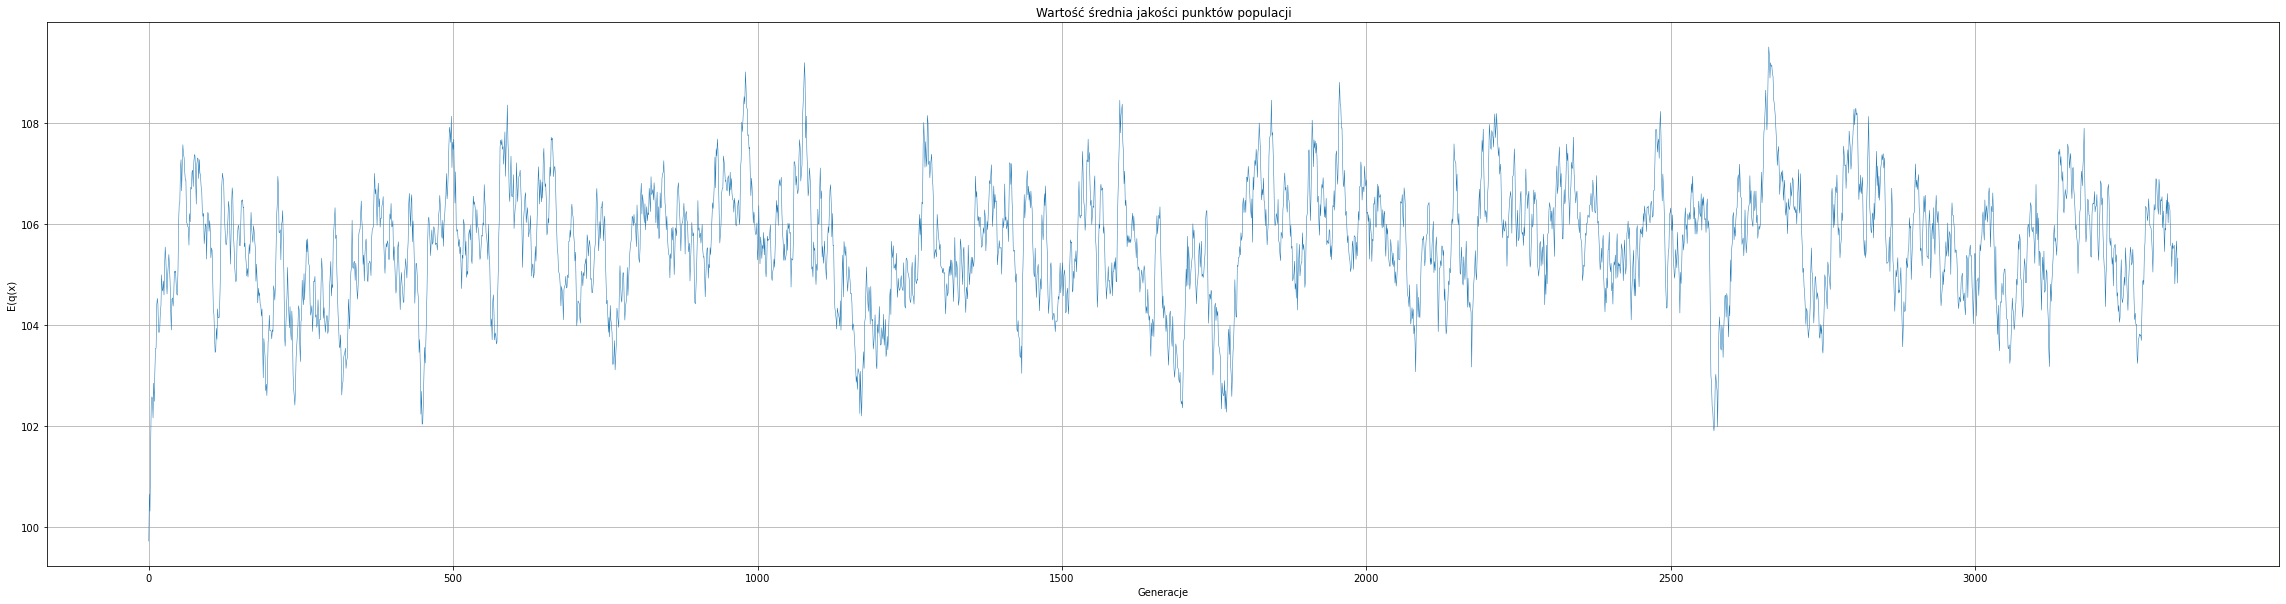

In [16]:
example_result = genetic_algorithm(profit_function, 0.05, 0.75, 300, total_budget)


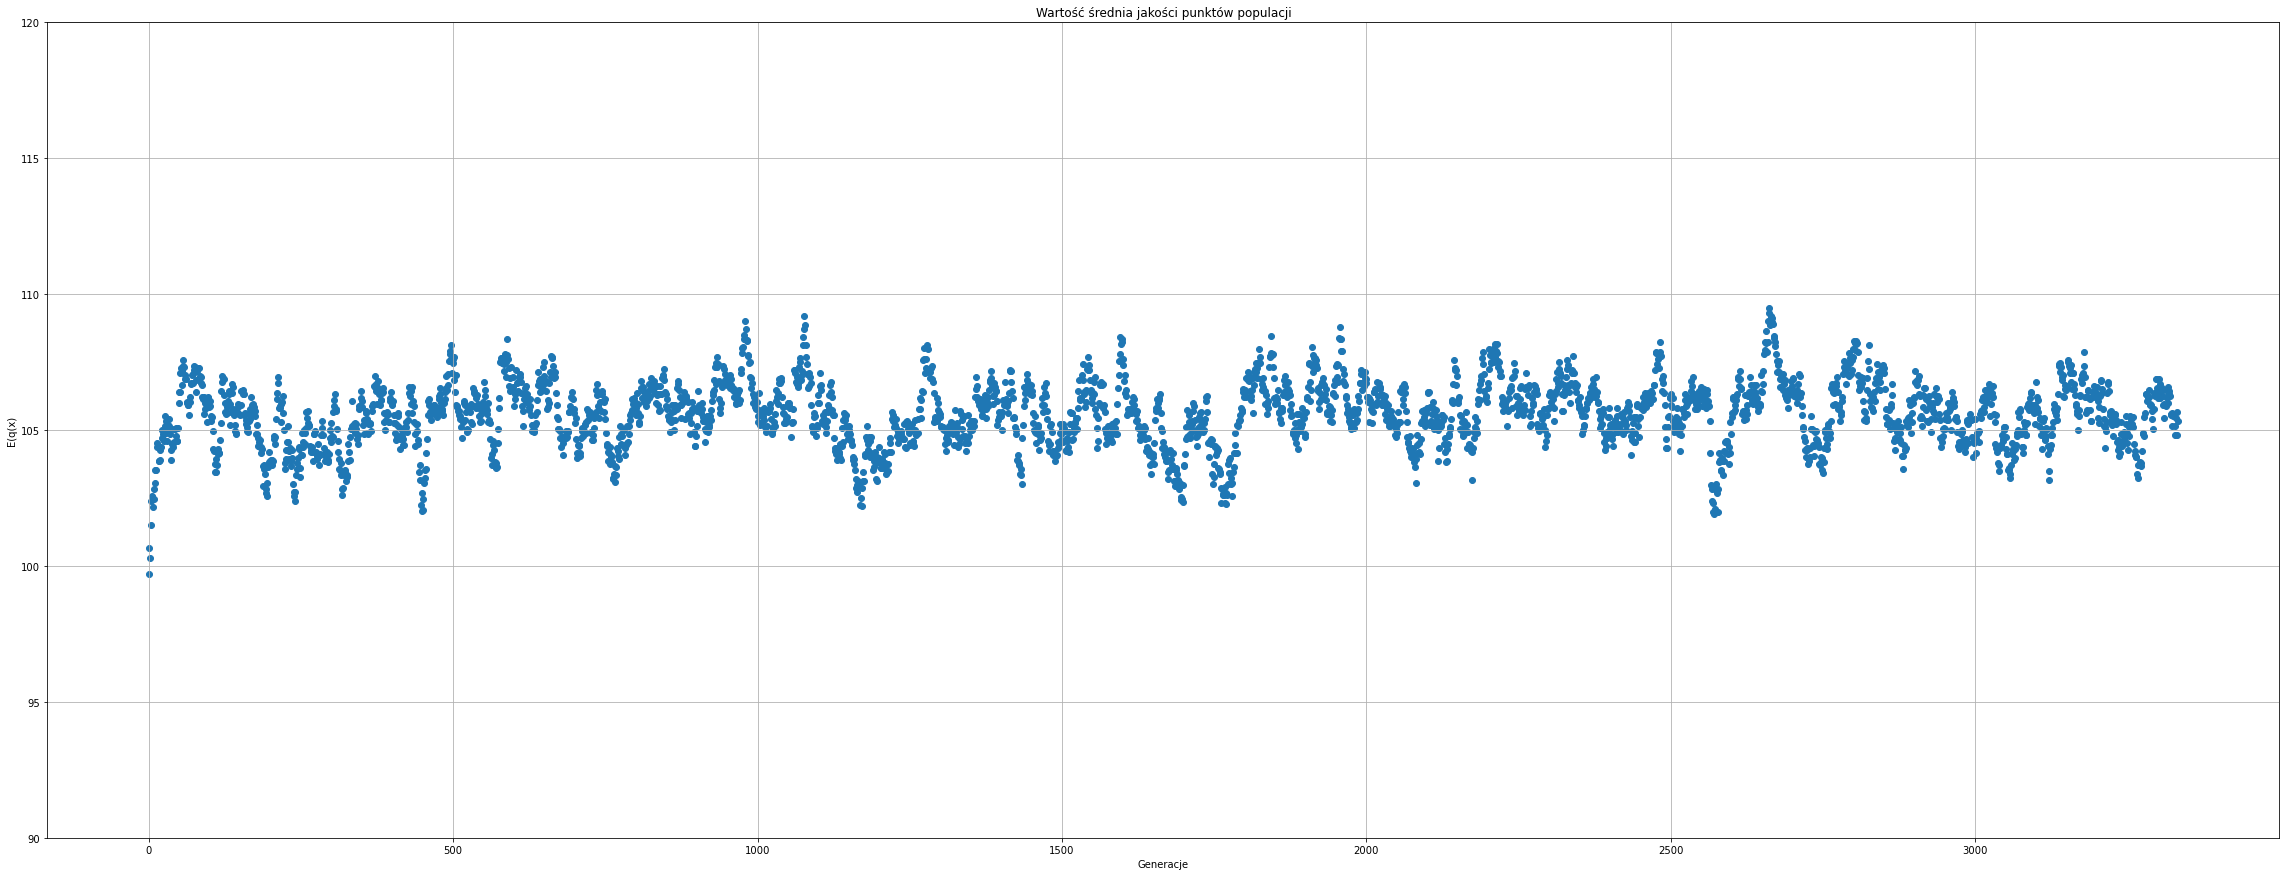

In [39]:
y = example_result[3]
x = np.arange(len(y))
plt.figure(figsize=(40, 15))
plt.scatter(x, y)
plt.title("Wartość średnia jakości punktów populacji")
plt.xlabel("Generacje")
plt.ylabel("E(q(x)")
plt.ylim(90, 120)
plt.grid(b=True)
plt.show()

# Badanie wpływu prawdopodobieństwa mutacji na działanie AG

In [ ]:
mean_best_values = np.empty([5])
for i in range(5):
    best_values = np.empty(25)
    for j in range(25):
        result = genetic_algorithm(profit_function, p_mutations[i], 0.75, 300, total_budget)
        best_values[j] = result[0][0]
    mean_best_values[i] = best_values.sum() / 25
print("Średnie najlepsze wyniki dla populacji:")
for k in range(5):
    print(f"Pr. mutacji: {p_mutations[k]}, optimum: {mean_best_values[i]}")

# Wykres dla w miarę optymalnego p_mutation = 0.01

In [41]:
example_result = genetic_algorithm(profit_function, 0.01, 0.75, 300, total_budget)

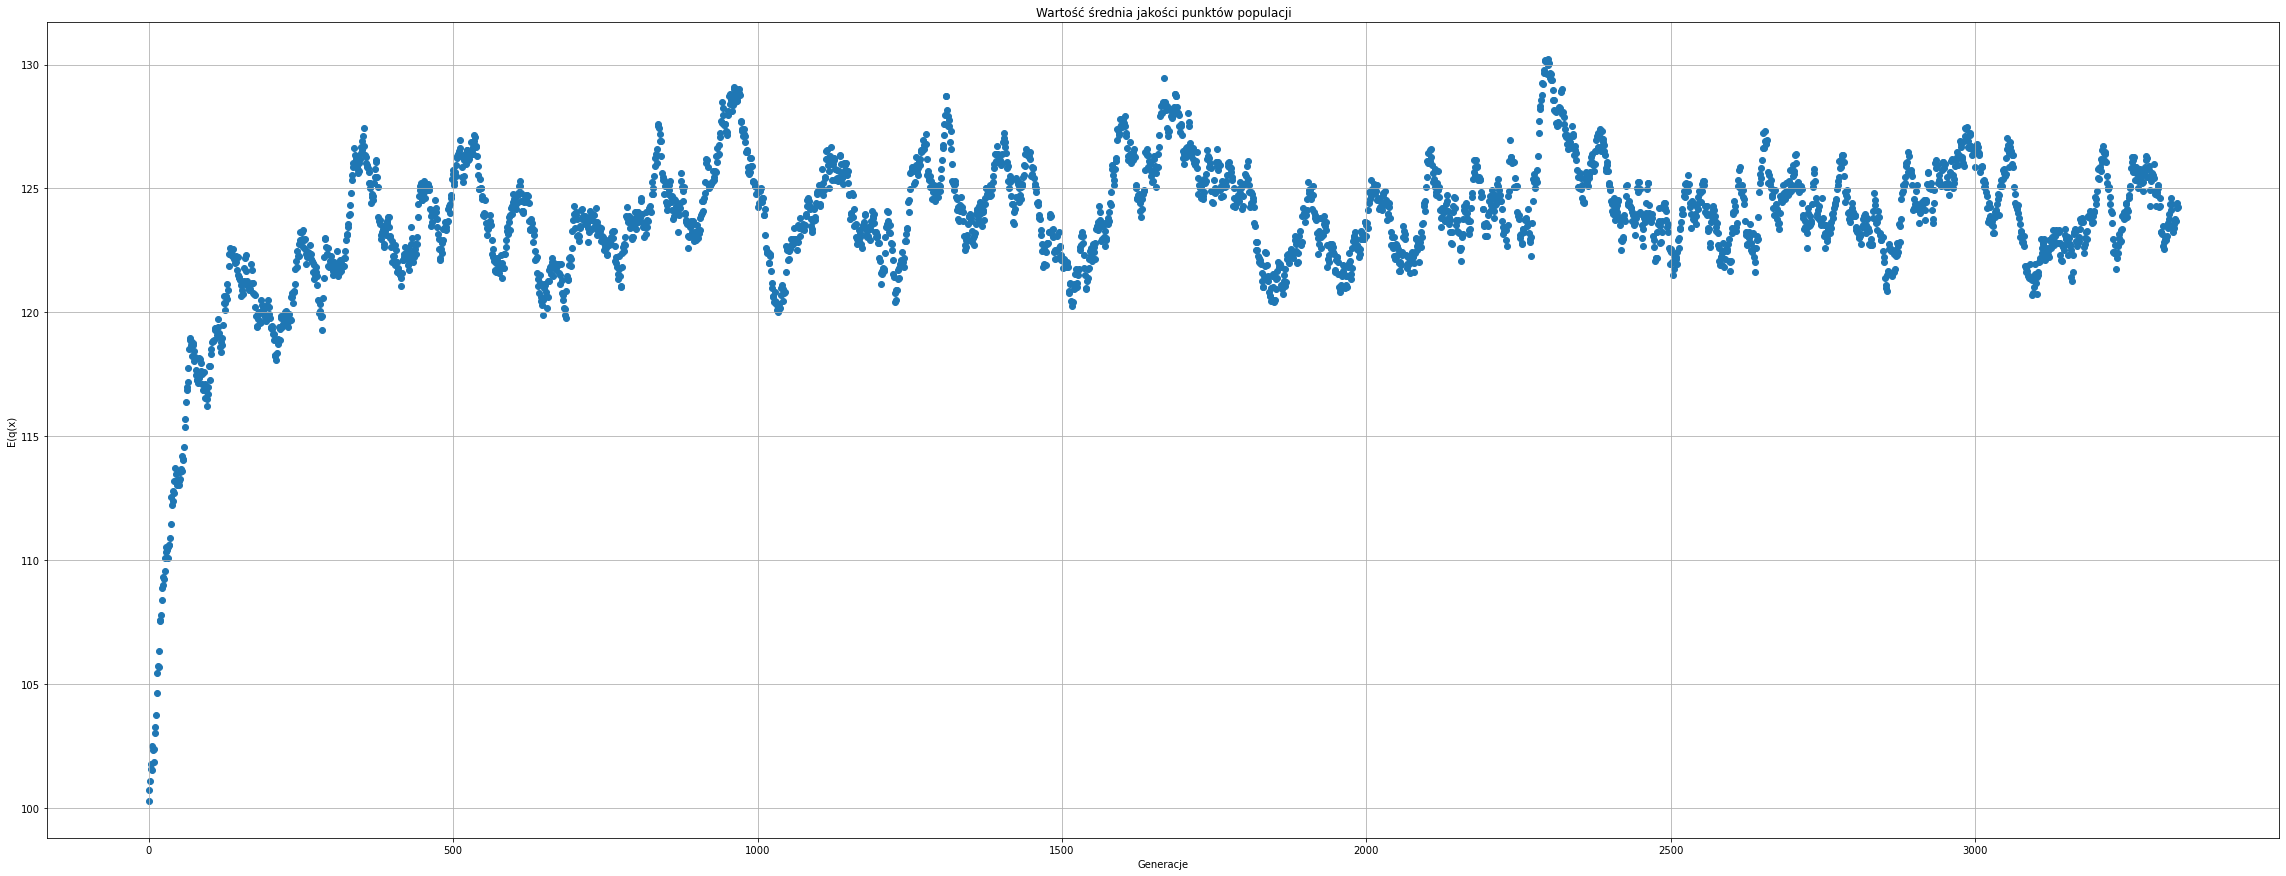

In [42]:
y = example_result[3]
x = np.arange(len(y))
plt.figure(figsize=(40, 15))
plt.scatter(x, y)
plt.title("Wartość średnia jakości punktów populacji")
plt.xlabel("Generacje")
plt.ylabel("E(q(x)")
plt.grid(b=True)
plt.show()

# Badanie wpływu prawdopodobieństwa krzyżowania na działanie AG

In [ ]:
mean_best_values = np.empty([5])
for i in range(5):
    best_values = np.empty(25)
    for j in range(25):
        result = genetic_algorithm(profit_function, 0.05, p_crossovers[i], 300, total_budget)
        best_values[j] = result[0][0]
    mean_best_values[i] = best_values.sum() / 25
print("Średnie najlepsze wyniki dla populacji:")
for k in range(5):
    print(f"Pr. krzyżowania: {p_crossovers[k]}, optimum: {mean_best_values[i]}")

# Wykres dla w miarę optymalnego p_crossing = 0.9

In [ ]:
example_result = genetic_algorithm(profit_function, 0.05, 0.9, 300, total_budget)

In [ ]:
y = example_result[3]
x = np.arange(len(y))
plt.figure(figsize=(40, 15))
plt.scatter(x, y)
plt.title("Wartość średnia jakości punktów populacji")
plt.xlabel("Generacje")
plt.ylabel("E(q(x)")
plt.grid(b=True)
plt.show()

# Optymalne działanie dla wybranych parametrów population_size = 300, p_mutation = 0.01, p_crossing = 0.9

In [ ]:
example_result = genetic_algorithm(profit_function, 0.01, 0.9, 300, total_budget)

In [ ]:
y = example_result[3]
x = np.arange(len(y))
plt.figure(figsize=(40, 15))
plt.scatter(x, y)
plt.title("Wartość średnia jakości punktów populacji")
plt.xlabel("Generacje")
plt.ylabel("E(q(x)")
plt.grid(b=True)
plt.show()